<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_GenAI/blob/main/NDVI_Emulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install rasterio
!pip install opencv-python-headless

import os
import numpy as np
import cv2  # OpenCV for image processing
import rasterio
from rasterio.errors import RasterioIOError
import matplotlib.pyplot as plt
import math



In [10]:
# --- (1) PLEASE MODIFY THE PATH HERE ---

# Replace 'YOUR_IMAGE_FOLDER' with the path to your folder within "My Drive"
# This is the folder containing your original images.
INPUT_FOLDER = '/content/drive/My Drive/poi_images_around_Trafalgar_Square' #@param{type:'string'}


Input folder: /content/drive/My Drive/poi_images_around_Trafalgar_Square
Output folder (created inside input folder): /content/drive/My Drive/poi_images_around_Trafalgar_Square/NDVI_Results_1
VARI (JPG/PNG) range will be dynamically determined using percentiles: 5-95

--- First Pass: Collecting VARI values for dynamic range calculation ---
Dynamically determined VARI range: [-0.5316, 0.3095]

--- Second Pass: Processing and saving results ---
Processing RGB (VARI): trafalgar_square_ChIJYxIC5M4EdkgR1KNQDHX_n1k_1.jpg
  -> Saved (Visualisation): /content/drive/My Drive/poi_images_around_Trafalgar_Square/NDVI_Results_1/trafalgar_square_ChIJYxIC5M4EdkgR1KNQDHX_n1k_1_VARI.png
Processing RGB (VARI): trafalgar_square_ChIJJ8HlTsUEdkgRgPkf7Km4LbQ_2.jpg
  -> Saved (Visualisation): /content/drive/My Drive/poi_images_around_Trafalgar_Square/NDVI_Results_1/trafalgar_square_ChIJJ8HlTsUEdkgRgPkf7Km4LbQ_2_VARI.png
Processing RGB (VARI): trafalgar_square_ChIJm8X-9M0EdkgR7OfNHW6yApM_3.jpg
  -> Saved (Vis

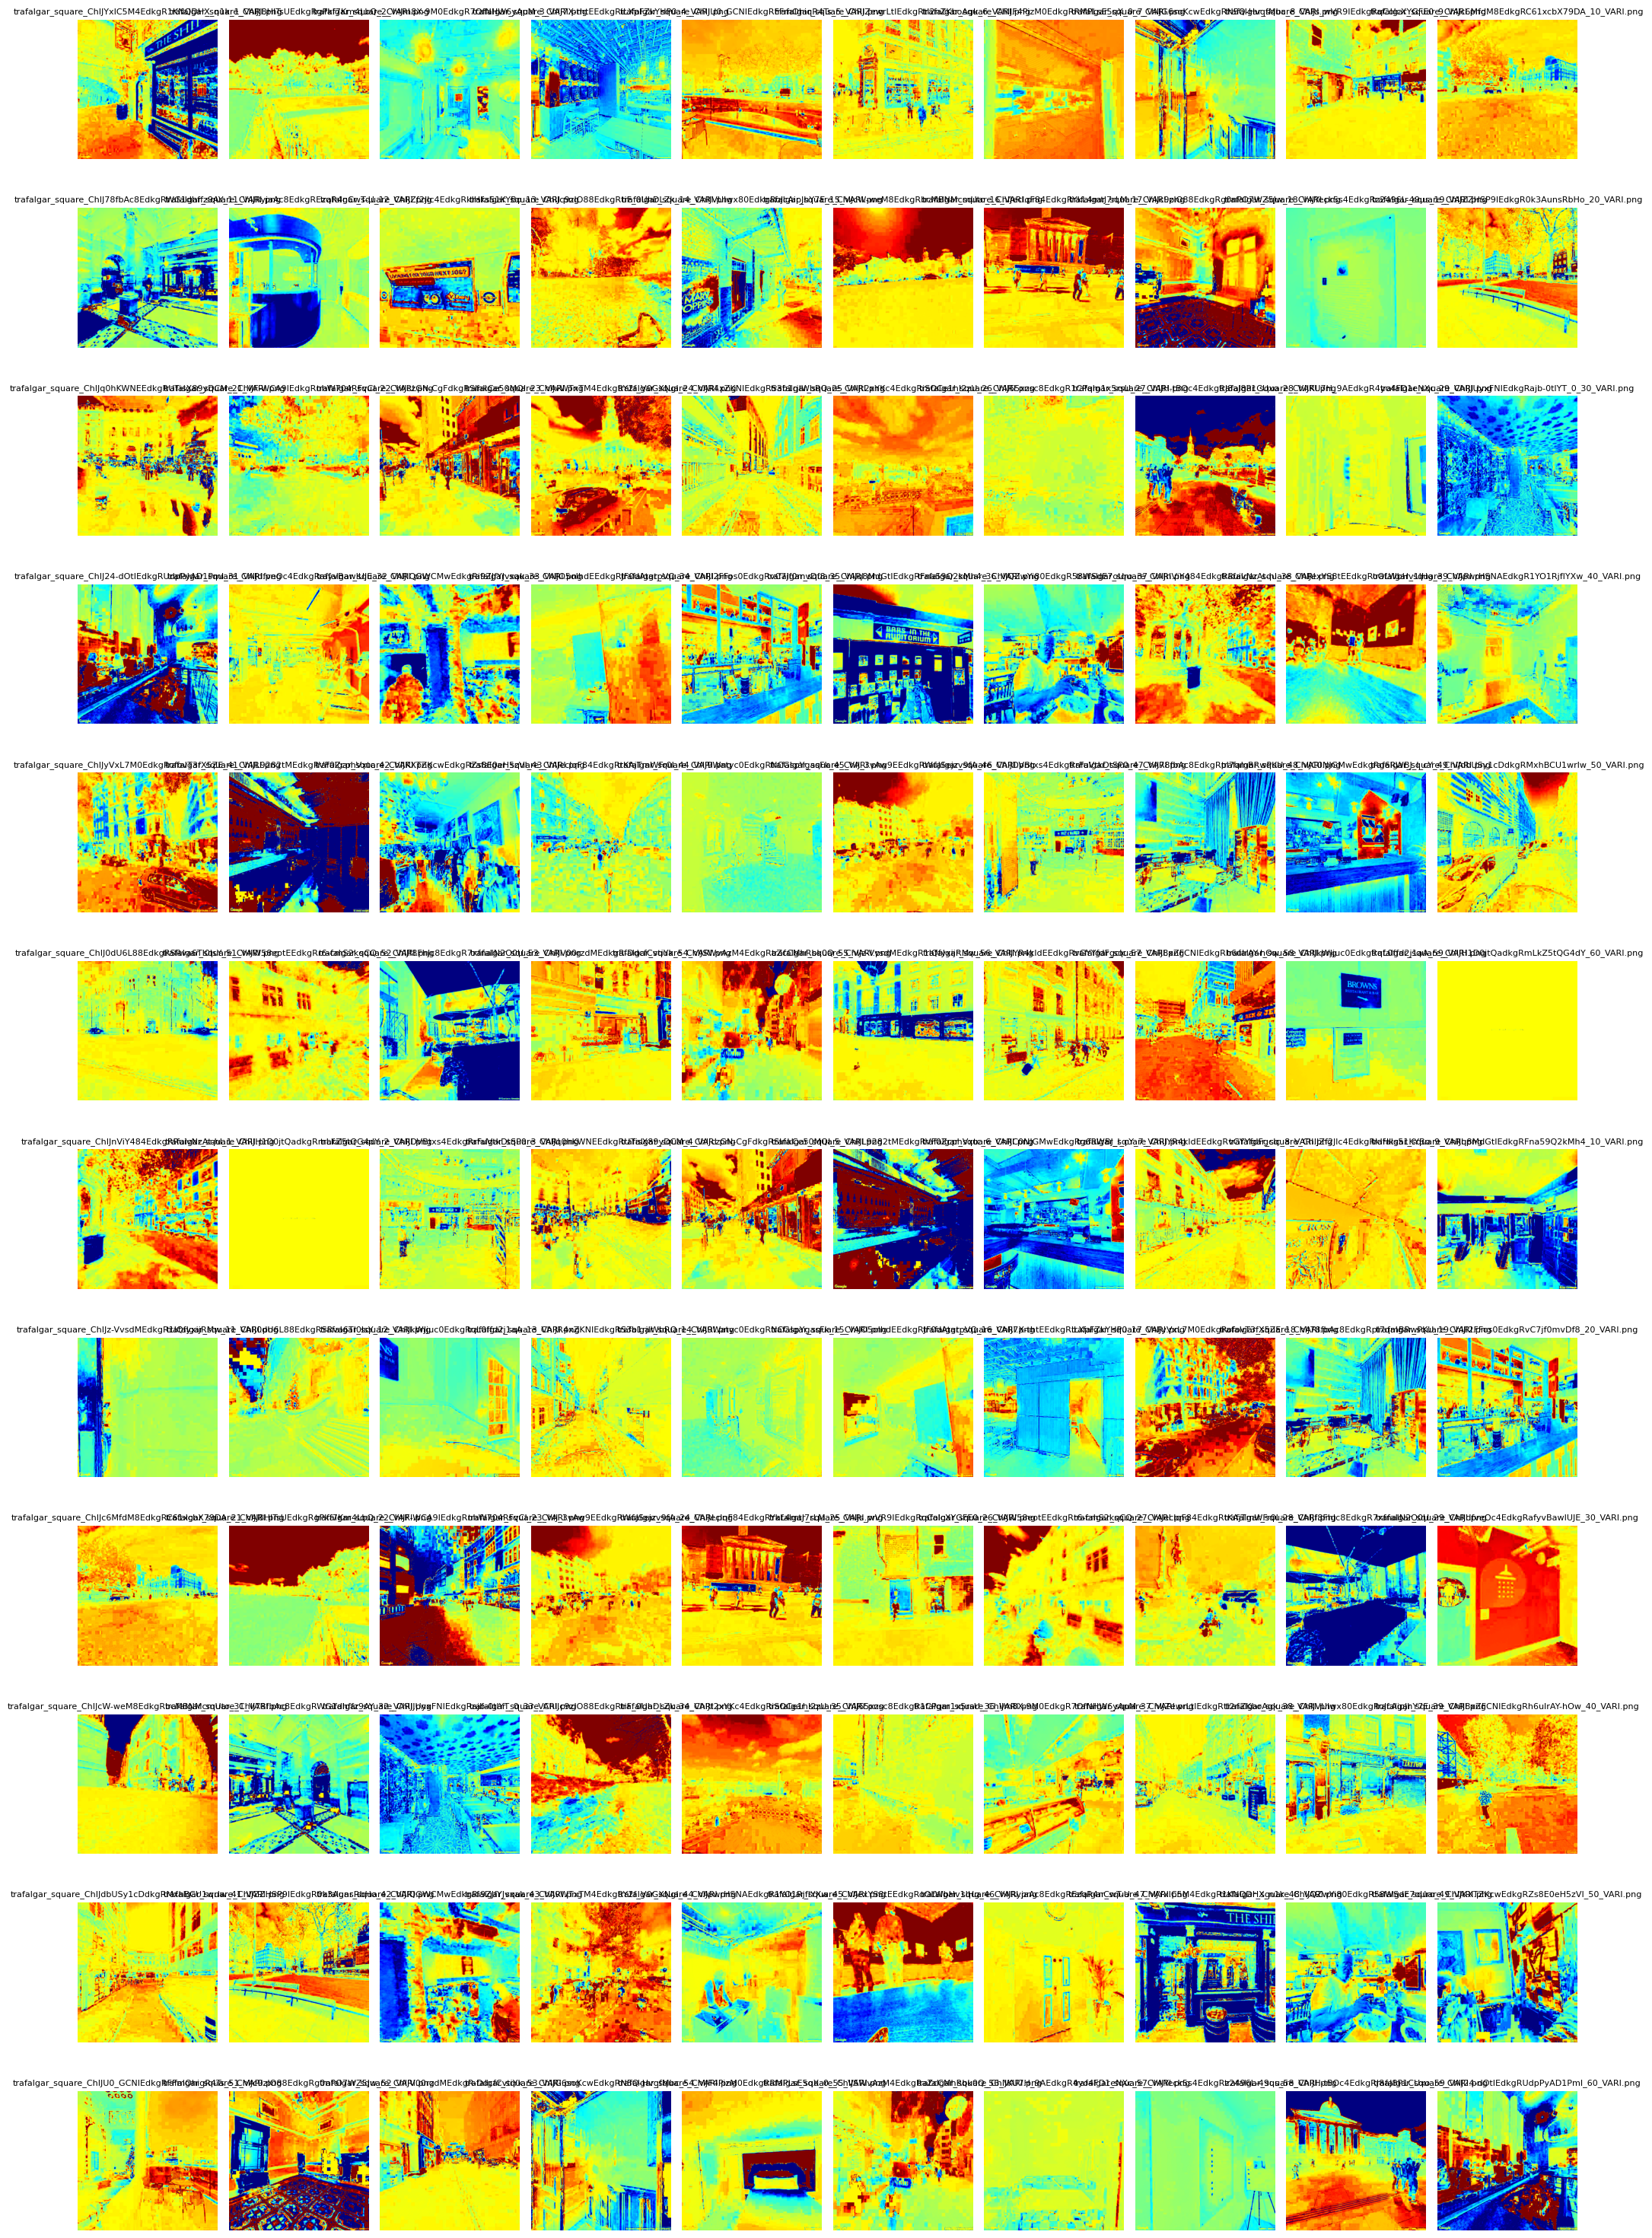

In [13]:


# --- (2) BAND SETTINGS FOR MULTISPECTRAL (TIF) IMAGES ---
NIR_BAND_INDEX = 7  # Example: Sentinel-2's Band 8 (index 7)
RED_BAND_INDEX = 3  # Example: Sentinel-2's Band 4 (index 3)

# --- (3) PERCENTILE SETTINGS FOR VARI (JPG/PNG) ---
LOWER_PERCENTILE = 5   # Example: Ignore the lowest 5% of VARI values
UPPER_PERCENTILE = 95  # Example: Ignore the highest 5% of VARI values

# --------------------------------------------------------

def get_unique_output_folder(parent_folder, folder_name="NDVI_Results"):
    """
    Checks if an output folder exists. If it does, appends a number
    to create a unique folder name.
    """
    output_folder_path = os.path.join(parent_folder, folder_name)
    counter = 1
    while os.path.exists(output_folder_path):
        unique_folder_name = f"{folder_name}_{counter}"
        output_folder_path = os.path.join(parent_folder, unique_folder_name)
        counter += 1
    return output_folder_path

# --- Create a unique output folder *inside* the input folder ---
OUTPUT_FOLDER = get_unique_output_folder(INPUT_FOLDER, folder_name="NDVI_Results")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"Input folder: {INPUT_FOLDER}")
print(f"Output folder (created inside input folder): {OUTPUT_FOLDER}")
print(f"VARI (JPG/PNG) range will be dynamically determined using percentiles: {LOWER_PERCENTILE}-{UPPER_PERCENTILE}")


def calculate_ndvi(multispectral_image_path, nir_band, red_band):
    """Calculates NDVI for a multispectral TIF image using Rasterio."""
    try:
        with rasterio.open(multispectral_image_path) as src:
            nir = src.read(nir_band).astype(np.float32)
            red = src.read(red_band).astype(np.float32)
            np.seterr(divide='ignore', invalid='ignore')
            denominator = nir + red
            ndvi = np.where(denominator == 0, 0, (nir - red) / denominator)
            meta = src.meta
            meta.update(dtype=rasterio.float32, count=1, compress='lzw')
            return ndvi, meta
    except RasterIOError as e:
        print(f"  [Error] Could not read TIF file (Invalid band index?): {e}")
        return None, None
    except Exception as e:
        print(f"  [Error] Failed processing TIF: {e}")
        return None, None

def calculate_vari(rgb_image_path):
    """Calculates VARI (Visible Atmospherically Resistant Index) for an RGB image."""
    try:
        img = cv2.imread(rgb_image_path)
        if img is None:
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_float = img_rgb.astype(np.float32) / 255.0
        r = img_float[:, :, 0]
        g = img_float[:, :, 1]
        b = img_float[:, :, 2]
        np.seterr(divide='ignore', invalid='ignore')
        denominator = r + g - b
        vari = np.where(denominator == 0, 0, (g - r) / denominator)
        return vari
    except Exception as e:
        return None

# --- First Pass: Collect all VARI values from JPG/PNG images ---
print("\n--- First Pass: Collecting VARI values for dynamic range calculation ---")
all_vari_values = []
jpg_png_files_to_process = []
preview_image_paths = [] # <-- NEW: List to hold preview image paths

for filename in os.listdir(INPUT_FOLDER):
    input_path = os.path.join(INPUT_FOLDER, filename)
    if os.path.commonpath([input_path]) == os.path.commonpath([OUTPUT_FOLDER]):
        continue
    if os.path.isdir(input_path):
        continue

    extension_lower = os.path.splitext(filename)[1].lower()

    if extension_lower in ['.jpg', '.jpeg', '.png']:
        vari_map = calculate_vari(input_path)
        if vari_map is not None:
            all_vari_values.extend(vari_map.flatten())
            jpg_png_files_to_process.append(filename)

if len(all_vari_values) > 0:
    VARI_MIN_RANGE_DYNAMIC = np.percentile(all_vari_values, LOWER_PERCENTILE)
    VARI_MAX_RANGE_DYNAMIC = np.percentile(all_vari_values, UPPER_PERCENTILE)
    print(f"Dynamically determined VARI range: [{VARI_MIN_RANGE_DYNAMIC:.4f}, {VARI_MAX_RANGE_DYNAMIC:.4f}]")
else:
    print("No JPG/PNG images found or processed for VARI calculation.")
    VARI_MIN_RANGE_DYNAMIC = -1.0
    VARI_MAX_RANGE_DYNAMIC = 1.0


# --- Second Pass: Process all images and save results ---
print("\n--- Second Pass: Processing and saving results ---")

for filename in os.listdir(INPUT_FOLDER):
    input_path = os.path.join(INPUT_FOLDER, filename)

    if os.path.commonpath([input_path]) == os.path.commonpath([OUTPUT_FOLDER]):
        continue
    if os.path.isdir(input_path):
        continue

    base_name, extension = os.path.splitext(filename)
    extension_lower = extension.lower()

    # --- Process Multispectral TIF/TIFF Images ---
    if extension_lower in ['.tif', '.tiff']:
        print(f"Processing TIF (NDVI): {filename}")
        ndvi_map, meta = calculate_ndvi(input_path, NIR_BAND_INDEX + 1, RED_BAND_INDEX + 1)
        if ndvi_map is not None:
            # 1. Save the scientific data (.tif)
            output_filename_data = f"{base_name}_NDVI.tif"
            output_path_data = os.path.join(OUTPUT_FOLDER, output_filename_data)
            with rasterio.open(output_path_data, 'w', **meta) as dst:
                dst.write(ndvi_map, 1)
            print(f"  -> Saved (Data): {output_path_data}")

            # 2. NEW: Create and save a .png preview
            output_filename_preview = f"{base_name}_NDVI_preview.png"
            output_path_preview = os.path.join(OUTPUT_FOLDER, output_filename_preview)

            # Normalise NDVI to [0, 255] using standard [-1, 1] range
            ndvi_clamped = np.clip(ndvi_map, -1.0, 1.0)
            ndvi_scaled = 127.5 * (ndvi_clamped + 1.0) # Maps [-1, 1] to [0, 255]
            ndvi_normalised_abs = ndvi_scaled.astype(np.uint8)
            ndvi_coloured = cv2.applyColorMap(ndvi_normalised_abs, cv2.COLORMAP_JET)

            cv2.imwrite(output_path_preview, ndvi_coloured)
            print(f"  -> Saved (Preview): {output_path_preview}")

            # 3. NEW: Add preview path to list
            preview_image_paths.append(output_path_preview)

    # --- Process Standard RGB JPG/PNG Images ---
    elif extension_lower in ['.jpg', '.jpeg', '.png']:
        print(f"Processing RGB (VARI): {filename}")
        vari_map = calculate_vari(input_path)

        if vari_map is not None:
            output_filename_img = f"{base_name}_VARI.png"
            output_path_img = os.path.join(OUTPUT_FOLDER, output_filename_img)

            min_val, max_val = VARI_MIN_RANGE_DYNAMIC, VARI_MAX_RANGE_DYNAMIC
            if max_val == min_val:
                min_val, max_val = -1.0, 1.0 # Fallback

            vari_clamped = np.clip(vari_map, min_val, max_val)
            vari_scaled = 255 * (vari_clamped - min_val) / (max_val - min_val)
            vari_normalised_abs = vari_scaled.astype(np.uint8)
            vari_coloured = cv2.applyColorMap(vari_normalised_abs, cv2.COLORMAP_JET)

            cv2.imwrite(output_path_img, vari_coloured)
            print(f"  -> Saved (Visualisation): {output_path_img}")

            # NEW: Add preview path to list
            preview_image_paths.append(output_path_img)

print("--- Processing Complete ---")


# --- NEW: Plotting Previews ---
print("\n--- Generating Previews ---")

if not preview_image_paths:
    print("No images were processed to preview.")
else:
    images_per_row = 10
    total_images = len(preview_image_paths)
    num_rows = math.ceil(total_images / images_per_row)

    # Set figure size (width, height in inches)
    plt.figure(figsize=(20, num_rows * 2.5)) # 20in width for 10 images, 2.5in height per row

    print(f"Displaying {total_images} previews in {num_rows} row(s)...")

    for i, img_path in enumerate(preview_image_paths):
        try:
            # Read image using matplotlib (handles RGB order correctly)
            img = plt.imread(img_path)

            ax = plt.subplot(num_rows, images_per_row, i + 1)
            plt.imshow(img)

            # Use a smaller font for the title and wrap text
            title = os.path.basename(img_path)
            ax.set_title(title, fontsize=8, wrap=True)
            plt.axis('off')

        except Exception as e:
            print(f"Could not load preview for {img_path}: {e}")
            # Plot a placeholder if image fails
            ax = plt.subplot(num_rows, images_per_row, i + 1)
            plt.text(0.5, 0.5, 'Error loading', horizontalalignment='center', verticalalignment='center')
            plt.axis('off')

    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()